# Engagement across-dataset prediction

Song, Finn, & Rosenberg (2021) Neural signatures of attentional engagement during narratives and its consequences for event memory, bioRxiv, doi.org/10.1101/2020.08.26.266320

Code by Hayoung Song (hyssong@uchicago.edu)

This code trains a support vector regression model to predict moment-by-moment behavioral data (group-average engagement) from moment-by-moment fMRI measures (dynamic functional connectivity) in all participants from one dataset (e.g., *Paranoia*), and tests the model on an external dataset (e.g., *Sherlock*). Selected features, or functional connections, are those that were significantly correlated (*p* < .01) with behavior in every cross-validation fold in the within-dataset prediction analysis. The trained SVR is applied to every subject in the test dataset to predict behavior (group-average engagement) from time-resolved functional connectivity. Model performance is evaluated with the Fisher's *z*-transformed Pearson's *r* between the predicted and observed behavioral timecourses, averaged across participants in the test dataset. Actual model performance is compared with permuted null distribution, where null models predict phase-randomized behavioral timecourses (one-tailed test, iteration=1,000).

## Import libraries

In [1]:
import numpy as np
import os
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
%matplotlib inline

/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Settings

In [2]:
dataset_learn = 'paranoia'
dataset_test = 'sherlock'

thres = 0.01
nR = 122
path = os.path.dirname(os.path.dirname(os.getcwd()))

learn_nsubj = scipy.io.loadmat(path + '/data/hyperparameters.mat')[dataset_learn + '_nsubj'][0][0]
learn_wsize = scipy.io.loadmat(path + '/data/hyperparameters.mat')[dataset_learn + '_wsize'][0]
learn_nT = scipy.io.loadmat(path + '/data/hyperparameters.mat')[dataset_learn + '_nT'][0][0]

test_nsubj = scipy.io.loadmat(path + '/data/hyperparameters.mat')[dataset_test + '_nsubj'][0][0]
test_wsize = scipy.io.loadmat(path + '/data/hyperparameters.mat')[dataset_test + '_wsize'][0]
test_nT = scipy.io.loadmat(path + '/data/hyperparameters.mat')[dataset_test + '_nT'][0][0]

print('Across-dataset prediction')

learn_wsize = learn_wsize[1]
test_wsize = test_wsize[1]
print('  model learn from = '+str(dataset_learn)+' win'+str(learn_wsize))
print('  model testing    = '+str(dataset_test)+' win'+str(test_wsize))

Across-dataset prediction
  model learn from = paranoia win40
  model testing    = sherlock win30


## Load behavior data

In [3]:
engagement_learn = scipy.io.loadmat(path + '/data_processed/'+ dataset_learn + '/win' + str(learn_wsize) + '/sliding-engagement.mat')['sliding_engagement'][:,0]
engagement_test = scipy.io.loadmat(path + '/data_processed/'+ dataset_test + '/win' + str(test_wsize) + '/sliding-engagement.mat')['sliding_engagement'][:,0]
print('  model learn: engagement shape '+str(engagement_learn.shape))
print('  model test : engagement shape '+str(engagement_test.shape))

  model learn: engagement shape (1270,)
  model test : engagement shape (1946,)


## Load brain data

In [4]:
dynFeat_learn = scipy.io.loadmat(path + '/data_processed/' + dataset_learn + '/win'+str(learn_wsize) + '/sliding-dynFeat.mat')['dynFeat']
dynFeat_learn = scipy.stats.zscore(dynFeat_learn,2,nan_policy='omit') # zscore per feature
dynFeat_test = scipy.io.loadmat(path + '/data_processed/' + dataset_test + '/win'+str(test_wsize) + '/sliding-dynFeat.mat')['dynFeat']
dynFeat_test = scipy.stats.zscore(dynFeat_test,2,nan_policy='omit') # zscore per feature
print('  model learn: brain entire feature shape '+str(dynFeat_learn.shape))
print('  model test : brain entire feature shape '+str(dynFeat_test.shape))

/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2413: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(a=a, axis=axis, keepdims=True)
/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


  model learn: brain entire feature shape (22, 7381, 1270)
  model test : brain entire feature shape (17, 7381, 1946)


## Load brain features
In a within-dataset prediction, we conducted feature selection in each cross-validation (functional connections that were significantly correlated with group-average engagement with the training sample). Here, we use functional connections that were selected in *every* round of cross-validation. (The code runs with the saved output from within-dataset prediction.)

In [5]:
savepath=path+'/result/dynPred/'+str(dataset_learn)+'/win'+str(learn_wsize)
pos_feat = scipy.io.loadmat(savepath + '/within_engagement.mat')['pos_feat']
neg_feat = scipy.io.loadmat(savepath + '/within_engagement.mat')['neg_feat']
pos_feat, neg_feat = np.average(pos_feat,0), np.average(neg_feat,0)
for i1 in range(nR):
    for i2 in range(nR):
        if pos_feat[i1,i2]<1:
            pos_feat[i1,i2]=0
        if neg_feat[i1,i2]<1:
            neg_feat[i1,i2]=0
print(' #pos = '+str(int(np.sum(pos_feat)/2)), ', #neg = '+str(int(np.sum(neg_feat)/2)))
all_feat = pos_feat+neg_feat
featid = []
ii = -1
for i1 in range(nR-1):
    for i2 in range(i1+1,nR):
        ii=ii+1
        if all_feat[i1,i2]==1:
            featid.append(ii)

 #pos = 125 , #neg = 80


In [6]:
dynFeat_learn = dynFeat_learn[:,featid,:]
dynFeat_test = dynFeat_test[:,featid,:]
print('  model learn: brain selected feature shape '+str(dynFeat_learn.shape))
print('  model test : brain selected feature shape '+str(dynFeat_test.shape))

  model learn: brain selected feature shape (22, 205, 1270)
  model test : brain selected feature shape (17, 205, 1946)


In [7]:
train_feat = np.transpose(dynFeat_learn,(1,0,2))
train_feat = np.reshape(train_feat,(train_feat.shape[0],train_feat.shape[1]*train_feat.shape[2]))

train_engagement = []
for sub in range(learn_nsubj):
    train_engagement.append(engagement_learn)
train_engagement = np.asarray(train_engagement)
train_engagement = np.reshape(train_engagement, (train_engagement.shape[0] * train_engagement.shape[1]))

# if several TRs are removed
rmtr_train = []
for tm in range(train_feat.shape[1]):
    if np.all(np.isnan(train_feat[:,tm])):
        rmtr_train.append(tm)
rmtr_train = np.asarray(rmtr_train)
if len(rmtr_train)>0:
    train_feat = np.delete(train_feat,rmtr_train,1)
    train_engagement = np.delete(train_engagement,rmtr_train,0)

In [8]:
nanidx = []
for ft in range(train_feat.shape[0]):
    if np.any(np.isnan(train_feat[ft,:])):
        nanidx.append(ft)
for subj in range(dynFeat_test.shape[0]):
    for ft in range(dynFeat_test.shape[1]):
        if dataset_test=='sherlock' and subj==4:
            pass
        else:
            if np.any(np.isnan(dynFeat_test[subj,ft,:])):
                nanidx.append(ft)
nanidx = np.unique(nanidx)
print('NaN = '+str(nanidx))

if len(nanidx)>0:
    train_feat = np.delete(train_feat,nanidx,0)
    dynFeat_test = np.delete(dynFeat_test,nanidx,1)

NaN = [ 31  71 145 170]


## Support vector regression with non-linear kernel

In [9]:
print('SVR prediction with model learned from '+str(dataset_learn))
print('  train feature   : '+str(train_feat.T.shape))
print('  train engagement: '+str(train_engagement.shape))

clf = []
clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(train_feat.T, train_engagement)
print('Training done!')

SVR prediction with model learned from paranoia
  train feature   : (27940, 201)
  train engagement: (27940,)
Training done!


In [10]:
output_acc, output_eval = [], []
for test_sub in range(test_nsubj):
    test_feat = dynFeat_test[test_sub, :, :]
    test_behavior = engagement_test

    rmtr_test = []
    for tm in range(test_feat.shape[1]):
        if np.all(np.isnan(test_feat[:, tm])):
            rmtr_test.append(tm)
    rmtr_test = np.asarray(rmtr_test)
    if len(rmtr_test) > 0:
        test_feat = np.delete(test_feat, rmtr_test, 1)
        test_behavior = np.delete(test_behavior, rmtr_test, 0)

    predicted = clf.predict(test_feat.T)
    output_acc.append(predicted)

    # evaluate
    pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
    mse = metrics.mean_squared_error(test_behavior, predicted)
    rsq = metrics.r2_score(test_behavior, predicted)
    output_eval.append([pearsonr[0], mse, rsq])
    print(' subj ' + str(test_sub + 1) + ' / ' + str(test_nsubj) + ': pearson r=' + str(
            np.round(pearsonr[0], 3)), ', mse=' + str(np.round(mse, 3)) + ', rsq=' + str(np.round(rsq, 3)))
    print('              (train) ft ' + str(train_feat.shape[1]) + ', beh ' + str(train_engagement.shape[0]) +
              ', (test) ft ' + str(test_feat.shape[1]) + ', beh ' + str(test_behavior.shape[0]))

output_acc, output_eval = np.asarray(output_acc), np.asarray(output_eval)

 subj 1 / 17: pearson r=0.231 , mse=0.963, rsq=0.037
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 2 / 17: pearson r=0.28 , mse=0.961, rsq=0.038
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 3 / 17: pearson r=0.304 , mse=0.916, rsq=0.084
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 4 / 17: pearson r=0.276 , mse=0.937, rsq=0.062
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 5 / 17: pearson r=0.129 , mse=1.107, rsq=-0.108
              (train) ft 27940, beh 27940, (test) ft 1895, beh 1895
 subj 6 / 17: pearson r=-0.027 , mse=1.18, rsq=-0.18
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 7 / 17: pearson r=0.318 , mse=0.919, rsq=0.08
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 8 / 17: pearson r=0.233 , mse=1.003, rsq=-0.003
              (train) ft 27940, beh 27940, (test) ft 1946, beh 1946
 subj 9 / 17: pearson r=-0.037 ,

/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Check cross-validation prediction accuracy

Prediction result (mean of cross-validations): sherlock
 pearson r = 0.188
 MSE       = 1.022
 r-squared = -0.023


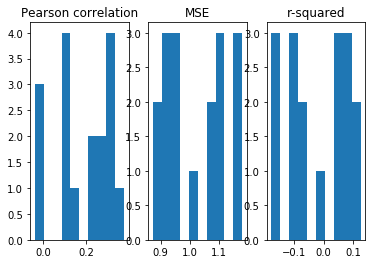

In [11]:
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval[:,2])
axs[2].set_title('r-squared')

print('Prediction result (mean of cross-validations): '+dataset_test)
print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval[:,2]),3)))

## Save output

In [12]:
savepath=path+'/result/dynPred/'+str(dataset_test)+'/win'+str(test_wsize)
if os.path.exists(savepath)==0:
    os.makedirs(savepath)
result = {'acc': output_acc, 'eval': output_eval}
scipy.io.savemat(savepath+'/across_engagement.mat', result)

## Non-parametric permutation tests

In [13]:
niter = 2
# permutation takes huge amount of time, so let's try with small number

engagement_learn_surr = scipy.io.loadmat(path+'/data_processed/'+dataset_learn+'/win'+str(learn_wsize)+'/sliding-engagement-surr.mat')['sliding_surr_engagement'][:,:niter]
engagement_test_surr = scipy.io.loadmat(path+'/data_processed/'+dataset_test+'/win'+str(test_wsize)+'/sliding-engagement-surr.mat')['sliding_surr_engagement'][:,:niter]
print('[learn] phase randomized engagement rating: shape '+str(engagement_learn_surr.shape))
print('[test]  phase randomized engagement rating: shape '+str(engagement_test_surr.shape))

[learn] phase randomized engagement rating: shape (1270, 2)
[test]  phase randomized engagement rating: shape (1946, 2)


In [14]:
if not os.path.exists(savepath+'/across_engagement_null'):
    os.makedirs(savepath+'/across_engagement_null')

print('Null prediction results: iter = '+str(niter))
surr_pearsonr, surr_mse, surr_rsq = [], [], []
for iter in range(niter):
    engagement_learn = engagement_learn_surr[:,iter]
    
    train_engagement = []
    for sub in range(learn_nsubj):
        train_engagement.append(engagement_learn)
    train_engagement = np.asarray(train_engagement)
    train_engagement = np.reshape(train_engagement, (train_engagement.shape[0] * train_engagement.shape[1]))
    
    # if several TRs are removed
    if len(rmtr_train)>0:
        train_engagement = np.delete(train_engagement, rmtr_train,0)
    
    clf = []
    clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        clf.fit(train_feat.T, train_engagement)
    
    surr_acc, surr_eval = [], []
    for test_sub in range(test_nsubj):
        test_feat = dynFeat_test[test_sub,:,:]
        test_behavior = engagement_test_surr[:,iter]
        
        rmtr_test = []
        for tm in range(test_feat.shape[1]):
            if np.all(np.isnan(test_feat[:,tm])):
                rmtr_test.append(tm)
        rmtr_test = np.asarray(rmtr_test)
        if len(rmtr_test)>0:
            test_feat = np.delete(test_feat, rmtr_test, 1)
            test_behavior = np.delete(test_behavior, rmtr_test,0)
        
        predicted = clf.predict(test_feat.T)
        surr_acc.append(predicted)
        
        # evaluate
        pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
        mse = metrics.mean_squared_error(test_behavior, predicted)
        rsq = metrics.r2_score(test_behavior, predicted)
        surr_eval.append([pearsonr[0], mse, rsq])
        
    surr_acc, surr_eval = np.asarray(surr_acc), np.asarray(surr_eval)
    surr_pearsonr.append(surr_eval[:,0])
    surr_mse.append(surr_eval[:,1])
    surr_rsq.append(surr_eval[:,2])
    print('null ' + str(iter + 1) + ' / ' + str(niter)+
          ' : pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(surr_eval[:,0]))),3))+
          ', mse = '+str(np.round(np.mean(surr_eval[:,1]),3))+
          ', rsq = '+str(np.round(np.mean(surr_eval[:,2]),3)))
    result = {'acc':surr_acc, 'eval':surr_eval}
    scipy.io.savemat(savepath+'/across_engagement_null/null'+str(iter+1)+'.mat',result)

surr_pearsonr, surr_mse, surr_rsq = np.asarray(surr_pearsonr), np.asarray(surr_mse), np.asarray(surr_rsq)

Null prediction results: iter = 2


/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


null 1 / 2 : pearson r = -0.014, mse = 1.156, rsq = -0.156
null 2 / 2 : pearson r = -0.083, mse = 1.179, rsq = -0.182


/Users/hayoungsong/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
def onetail_p(real, null):
    p = (1 + np.sum(null>=real)) / (1+len(null))
    print(str(np.sum(null>=real))+' among '+str(len(null))+' null has higher r value than actual prediction')
    return p

In [16]:
p = onetail_p(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))), conv_z2r(np.average(conv_r2z(surr_pearsonr),1)))
print('p = '+str(np.round(p,3)))

0 among 2 null has higher r value than actual prediction
p = 0.333


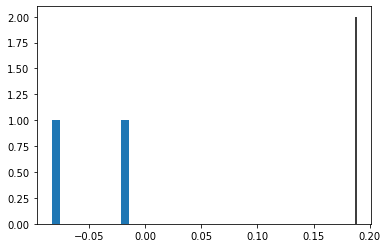

In [17]:
plt.hist(conv_z2r(np.average(conv_r2z(surr_pearsonr),1)))
plt.vlines(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),0,2)